In [20]:
import numpy as np
from random import seed
from random import sample
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from skimage.measure import regionprops_table
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join

In [21]:
nucleiPath = '/Volumes/Aortas/Aorta/segmentations/inducedRainbow/final/nuclei'
clusterPath = '/Volumes/Aortas/Aorta/segmentations/inducedRainbow/final/red'

In [22]:
df = pd.read_csv("/Volumes/Aortas/Aorta/results/inducedRainbow/allClusterSizesRed.csv")

In [24]:
clusterFolders = [x[0] for x in os.walk(clusterPath)]
clusterFolders = sorted(clusterFolders)

In [8]:
def fullNucImage(nucPath):
    scalingFactor = 10000
    for i in range(4):
        #build row block
        nuc1 =np.load(join(nucPath, "Cropped_IMG-" + str(4*i +1) + '_seg.npy'), allow_pickle=True).item()['masks']
        nuc2 =np.load(join(nucPath, "Cropped_IMG-" + str(4*i +2) + '_seg.npy'), allow_pickle=True).item()['masks']
        nuc3 =np.load(join(nucPath, "Cropped_IMG-" + str(4*i +3) + '_seg.npy'), allow_pickle=True).item()['masks']
        nuc4 =np.load(join(nucPath, "Cropped_IMG-" + str(4*i +4) + '_seg.npy'), allow_pickle=True).item()['masks']
        nuc1 = nuc1 + scalingFactor *(4*i +1)
        nuc1[nuc1 == (scalingFactor *(4*i +1))] = 0
        nuc2 = nuc2 + scalingFactor *(4*i +2)
        nuc2[nuc2 == (scalingFactor *(4*i +2))] = 0
        nuc3 = nuc3 + scalingFactor *(4*i +3)
        nuc3[nuc3 == (scalingFactor *(4*i +3))] = 0
        nuc4 = nuc4 + scalingFactor *(4*i +4)
        nuc4[nuc4 == (scalingFactor *(4*i +4))] = 0

        row = np.concatenate((nuc1, nuc2, nuc3, nuc4), axis = 1)
        if i == 0:
            nucImage = row
        else:
            nucImage = np.concatenate((nucImage, row), axis = 0)
    return nucImage

In [9]:
def centeroidPoints(arr):
    length = arr.shape[0]
    sum_y = np.sum(arr[:, 0])
    sum_x = np.sum(arr[:, 1])
    return sum_y/length, sum_x/length

In [10]:
def clusterCoord(cluster):
    singletons = []
    doublets = []
    higher = []
    marked = []
    for key in cluster:
        exclude = False
        for i in range(len(cluster[key])):
            if df[df['label'] == cluster[key][i]].to_numpy().size == 0:
                print(cluster[key])
                exclude = True
        if exclude == False:
            if len(cluster[key]) == 1:
                singletons.append(df[df['label'] == cluster[key][0]][['centroid-0', 'centroid-1']].to_numpy()[0])
                marked.append(df[df['label'] == cluster[key][0]][['centroid-0', 'centroid-1']].to_numpy()[0])
            elif len(cluster[key]) == 2:
                points = np.asarray([df[df['label'] == cluster[key][i]][['centroid-0', 'centroid-1']].to_numpy()[0] for i in range(len(cluster[key]))])
                centroid = centeroidPoints(points)
                doublets.append(centroid)
                marked.append(centroid)
                higher.append(centroid)
            elif len(cluster[key]) >2:
                points = np.asarray([df[df['label'] == cluster[key][i]][['centroid-0', 'centroid-1']].to_numpy()[0] for i in range(len(cluster[key]))])
                centroid = centeroidPoints(points)
                higher.append(centroid)
                marked.append(centroid)

    return np.asarray(marked), np.asarray(singletons), np.asarray(doublets), np.asarray(higher)

In [11]:
def kNN(array, neighbor):
    nbrs = NearestNeighbors(n_neighbors=neighbor, algorithm='ball_tree').fit(array)
    distances, indices = nbrs.kneighbors(array)
    return nbrs, distances, indices

In [12]:
def randomkNNDistances(nucIDs,len, df):
    selectedRandom = sample(nucIDs, len)
    dfRandom = df[df['label'].isin(selectedRandom)]
    nucCoordRandom = dfRandom[['centroid-0', 'centroid-1']].to_numpy()
    nbrsRandom = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(nucCoordRandom)
    distancesRand, indicesRandom = nbrsRandom.kneighbors(nucCoordRandom)
    return distancesRand

In [13]:
def randomkNNCluster(nucIDs,lens, df, simulationNumber):
    seed(42)
    markedRandom = []
    singletonRandom = []
    doubletRandom = []
    higherRandom = []
    for _ in range(simulationNumber):
        if lens[0] > 7:
            markedRandom.append(np.asarray(randomkNNDistances(nucIDs,lens[0], df)))
        if lens[1] > 7:
            singletonRandom.append(np.asarray(randomkNNDistances(nucIDs, lens[1], df)))
        if lens[2] > 7:
            doubletRandom.append(np.asarray((randomkNNDistances(nucIDs, lens[2], df))))
        if lens[3] > 7:
            higherRandom.append(np.asarray(randomkNNDistances(nucIDs, lens[3], df)))
    return np.asarray(markedRandom) , np.asarray(singletonRandom), np.asarray(doubletRandom), np.asarray(higherRandom)

In [14]:
def dataFrameHelp(age, aorta, values):
    df_help = pd.DataFrame(columns= ['age', 'aorta', 'value'])
    df_help['value'] = values
    df_help['age'] = age
    df_help['aorta'] = aorta
    return df_help

In [15]:
dfMarked1NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfMarked2NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfMarked3NN = pd.DataFrame(columns= ['age', 'aorta','value'])
dfMarked4NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfMarked5NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])

dfSingleton1NN = pd.DataFrame(columns= ['age', 'aorta',  'value'])
dfSingleton2NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfSingleton3NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfSingleton4NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfSingleton5NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])

dfDoublet1NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfDoublet2NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfDoublet3NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfDoublet4NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfDoublet5NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])

#higher = 2+
dfHigher1NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfHigher2NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfHigher3NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfHigher4NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])
dfHigher5NN = pd.DataFrame(columns= ['age', 'aorta', 'value'])

In [16]:
dfMarked = pd.DataFrame()


for folder in clusterFolders:
    os.chdir(folder)
    files = [f for f in listdir(folder) if isfile(join(folder, f)) if ".DS_Store" not in f if ".npy" in f if "._" not in f if "clusterSize" in f]
    for file in files:
        aorta = folder.split("/")[-1]
        age = folder.split("/")[-2]
        print(age)
        print(aorta)
        nucPath = join(nucleiPath, age, aorta)
        nucImage = fullNucImage(nucPath)
        prop_dict = regionprops_table(nucImage, properties = ('label', 'centroid'))
        df = pd.DataFrame(prop_dict)
        nucIDs = df['label'].tolist()
        cluster = np.load(join(folder,file), allow_pickle=True).item()
        marked, singletons, doublets, higher = clusterCoord(cluster)
        #lens = [len(marked), len(singletons), len(doublets), len(higher)]
        #markedRandom, singletonsRandom, doubletsRandom, higherRandom =  randomkNNCluster(nucIDs,lens, df, 1000)
        #markedRandom =  randomkNNCluster(nucIDs,lens, df, 1000)


        nbrsMarkedReal, distancesMarkedReal, indicesMarkedReal = kNN(marked, )
        dfHelp = pd.DataFrame(distancesMarkedReal)
        dfHelp["age"] = age
        dfHelp["aorta"] = aorta
        dfMarked = pd.concat([dfMarked, dfHelp])
        #nbrsSingletonsReal, distancesSingletonsReal, indicesSingletonsReal = kNN(singletons, 6)
        #nbrsDoubletsReal, distancesDoubletsReal, indicesDoubletsReal = kNN(doublets, 6)


        #dfMarked1NN = dfMarked1NN.append(dataFrameHelp(age, aorta, distancesMarkedReal[:,1]/np.mean(markedRandom[:,:,1].flatten()) -1 ))
        #dfMarked2NN = dfMarked2NN.append(dataFrameHelp(age, aorta, distancesMarkedReal[:,2]/np.mean(markedRandom[:,:,2].flatten()) -1 ))
        #dfMarked3NN = dfMarked3NN.append(dataFrameHelp(age, aorta, distancesMarkedReal[:,3]/np.mean(markedRandom[:,:,3].flatten()) -1 ))
        #dfMarked4NN = dfMarked4NN.append(dataFrameHelp(age, aorta, distancesMarkedReal[:,4]/np.mean(markedRandom[:,:,4].flatten()) -1 ))
        #dfMarked5NN = dfMarked5NN.append(dataFrameHelp(age, aorta, distancesMarkedReal[:,5]/np.mean(markedRandom[:,:,5].flatten()) -1 ))

        #dfSingleton1NN = dfSingleton1NN.append(dataFrameHelp(age, aorta, distancesSingletonsReal[:,1]/np.mean(singletonsRandom[:,:,1].flatten()) -1 ))
        #dfSingleton2NN = dfSingleton2NN.append(dataFrameHelp(age, aorta, distancesSingletonsReal[:,2]/np.mean(singletonsRandom[:,:,2].flatten()) -1 ))
        #dfSingleton3NN = dfSingleton3NN.append(dataFrameHelp(age, aorta, distancesSingletonsReal[:,3]/np.mean(singletonsRandom[:,:,3].flatten()) -1 ))
        #dfSingleton4NN = dfSingleton4NN.append(dataFrameHelp(age, aorta, distancesSingletonsReal[:,4]/np.mean(singletonsRandom[:,:,4].flatten()) -1 ))
        #dfSingleton5NN = dfSingleton5NN.append(dataFrameHelp(age, aorta, distancesSingletonsReal[:,5]/np.mean(singletonsRandom[:,:,5].flatten()) -1 ))

        #dfDoublet1NN = dfDoublet1NN.append(dataFrameHelp(age, aorta, distancesDoubletsReal[:,1]/np.mean(doubletsRandom[:,:,1].flatten()) -1 ))
        #dfDoublet2NN = dfDoublet2NN.append(dataFrameHelp(age, aorta, distancesDoubletsReal[:,2]/np.mean(doubletsRandom[:,:,2].flatten()) -1 ))
        #dfDoublet3NN = dfDoublet3NN.append(dataFrameHelp(age, aorta, distancesDoubletsReal[:,3]/np.mean(doubletsRandom[:,:,3].flatten()) -1 ))
        #dfDoublet4NN = dfDoublet4NN.append(dataFrameHelp(age, aorta, distancesDoubletsReal[:,4]/np.mean(doubletsRandom[:,:,4].flatten()) -1 ))
        #dfDoublet5NN = dfDoublet5NN.append(dataFrameHelp(age, aorta, distancesDoubletsReal[:,5]/np.mean(doubletsRandom[:,:,5].flatten()) -1 ))

        if len(higher) > 7:
            nbrsHigherReal, distancesHigherReal, indicesHigherReal = kNN(higher, 6)
            #dfHigher1NN = dfHigher1NN.append(dataFrameHelp(age, aorta, distancesHigherReal[:,1]/np.mean(higherRandom[:,:,1].flatten()) -1 ))
            #dfHigher2NN = dfHigher2NN.append(dataFrameHelp(age, aorta, distancesHigherReal[:,2]/np.mean(higherRandom[:,:,2].flatten()) -1 ))
            #dfHigher3NN = dfHigher3NN.append(dataFrameHelp(age, aorta, distancesHigherReal[:,3]/np.mean(higherRandom[:,:,3].flatten()) -1 ))
            #dfHigher4NN = dfHigher4NN.append(dataFrameHelp(age, aorta, distancesHigherReal[:,4]/np.mean(higherRandom[:,:,4].flatten()) -1 ))
            #dfHigher5NN = dfHigher5NN.append(dataFrameHelp(age, aorta, distancesHigherReal[:,5]/np.mean(higherRandom[:,:,5].flatten()) -1 ))

10-21
aorta01
10-21
aorta02
10-21
aorta03
10-21
aorta04
10-21
aorta05
10-30
aorta01
10-30
aorta02
10-30
aorta03
10-30
aorta04
10-30
aorta05
10-30
aorta06
10-30
aorta07
10-60
aorta01
10-60
aorta02
10-60
aorta03
10-60
aorta04
10-60
aorta05
10-60
aorta06
21-30
aorta01
21-30
aorta02
21-30
aorta03
21-30
aorta04
21-30
aorta05
30-60
aorta01
30-60
aorta02
30-60
aorta03
30-60
aorta04
30-60
aorta05
5-10
aorta01
5-10
aorta02
5-10
aorta03
5-10
aorta04
5-10
aorta06
5-10
aorta07
5-10
aorta08
5-30
aorta01
5-30
aorta02
5-30
aorta03
5-30
aorta04
5-30
aorta05
5-30
aorta06
5-60
aorta01
5-60
aorta02
5-60
aorta03


In [ ]:
folder = clusterFolders[16]

In [ ]:
files = [f for f in listdir(folder) if isfile(join(folder, f)) if ".DS_Store" not in f if ".npy" in f if "._" not in f if "clusterSize" in f]
for file in files:
    aorta = folder.split("/")[-1]
    age = folder.split("/")[-2]
    print(age)
    print(aorta)
    nucPath = join(nucleiPath, age, aorta)
    nucImage = fullNucImage(nucPath)
    prop_dict = regionprops_table(nucImage, properties = ('label', 'centroid'))
    df = pd.DataFrame(prop_dict)

In [ ]:
df

In [ ]:
clusters = np.load(join(folder,file), allow_pickle=True).item()
clusters

In [ ]:
dfNucLabels = pd.DataFrame()
for index in clusters:
    dfHelp = pd.DataFrame({"label": clusters[index], "cluster": np.full(len(clusters[index]),index)})
    dfNucLabels = pd.concat([dfNucLabels, dfHelp], ignore_index= True)

In [ ]:
dfNucLabels

In [ ]:
dfMerged = df.merge(dfNucLabels, on="label", how="left")

In [ ]:
dfMerged

In [ ]:
dfMerged['cluster'] = dfMerged['cluster'].fillna(0)

In [ ]:
dfFiltered = dfMerged.loc[dfMerged["cluster"] > 0]

In [ ]:
dfFiltered

In [87]:
dfFiltered = dfFiltered.reset_index(drop=True)
dfFiltered = dfFiltered.reset_index(drop=False)

In [88]:
dfFiltered

,index,label,centroid-0,centroid-1,cluster
0,0,10052,26.653846,311.307692,15.0
1,1,10053,27.846154,181.461538,14.0
2,2,10092,48.320000,240.000000,32.0
3,3,10100,49.458333,321.750000,41.0
4,4,10109,55.500000,175.500000,35.0
...,...,...,...,...,...
853,853,160564,1453.444444,1233.740741,810.0
854,854,160568,1457.029412,1196.676471,811.0
855,855,160579,1462.962963,1160.111111,823.0
856,856,160587,1467.000000,1061.080000,818.0


In [76]:
nbrsNuc, distancesNuc, indicesNuc = kNN(dfFiltered.iloc[:,1:3], 17)

In [80]:
indicesNuc

array([[  0,   3,   2, ...,  11,  12,   8],
       [  1,   4,   5, ...,  14,  10,  11],
       [  2,   6,   1, ...,  13,  11,  14],
       ...,
       [855, 857, 851, ..., 842, 841, 852],
       [856, 804, 850, ..., 857, 846, 793],
       [857, 855, 854, ..., 852, 841, 856]])

In [77]:
distancesNuc

array([[  0.        ,  25.08159535,  74.52656711, ..., 161.62021147,
        168.41397154, 178.63528562],
       [  0.        ,  28.2891348 ,  50.28547752, ..., 211.04704956,
        216.44910166, 217.20055355],
       [  0.        ,  41.16022641,  62.0155614 , ..., 164.17560115,
        165.0061964 , 170.04118028],
       ...,
       [  0.        ,  18.33875715,  31.78424862, ..., 103.88782102,
        111.8232518 , 119.91167303],
       [  0.        ,  33.91955778,  56.05583288, ..., 116.92      ,
        118.30891712, 119.93615811],
       [  0.        ,  18.33875715,  21.17128204, ..., 102.57813777,
        114.5010917 , 116.92      ]])

In [41]:
dfHelp

,nucID,label
0,30124,11
1,30140,11
2,30172,11


[30051]
[40042]
[10053]
[10052]
[20051]
[40057]
[20115]
[30096]
[30124, 30140, 30172]
[40077]
[20097]
[30109, 30179]
[10092]
[40078]
[10109]
[20122]
[20133]
[10100]
[30141]
[40086]
[40102]
[40099]
[40115]
[20153]
[30181, 30216]
[40120]
[30199]
[40125, 40153]
[30197]
[40135]
[30221]
[10152]
[20232]
[20241]
[30241]
[10172]
[30249]
[20274]
[20267]
[20293, 20314, 20321]
[40204]
[40194]
[30335]
[20317, 20327, 20351, 20368, 20372]
[30325, 30358, 30389]
[30363, 30403]
[20357]
[20379]
[30362]
[30372, 30387]
[40247]
[40255]
[20385]
[20373]
[30422]
[10275]
[10258]
[40284]
[30414]
[40276]
[30444, 30493]
[40297, 40339]
[30439]
[20428, 20488, 20500]
[40308]
[10292]
[20438]
[20436]
[40314]
[20465]
[20475]
[30485]
[30523]
[30504]
[10314, 10319]
[30520, 30569]
[40333]
[20521]
[10323, 10354, 10367]
[20532]
[20543]
[40370]
[20536]
[30543]
[10350]
[30571]
[40371]
[20541]
[20545]
[20565, 20616]
[40394, 40408]
[40385]
[30615]
[30622]
[40399]
[40437]
[30631]
[40413]
[30658]
[30641]
[30654]
[30628]
[40430, 4

In [44]:
clusters

{11: [30051],
 13: [40042],
 14: [10053],
 15: [10052],
 16: [20051],
 20: [40057],
 21: [20115],
 22: [30096],
 24: [30124, 30140, 30172],
 26: [40077],
 27: [20097],
 28: [30109, 30179],
 32: [10092],
 33: [40078],
 35: [10109],
 36: [20122],
 38: [20133],
 41: [10100],
 43: [30141],
 44: [40086],
 45: [40102],
 46: [40099],
 50: [40115],
 51: [20153],
 53: [30181, 30216],
 54: [40120],
 55: [30199],
 56: [40125, 40153],
 57: [30197],
 58: [40135],
 60: [30221],
 61: [10152],
 64: [20232],
 65: [20241],
 68: [30241],
 70: [10172],
 71: [30249],
 73: [20274],
 78: [20267],
 79: [20293, 20314, 20321],
 80: [40204],
 82: [40194],
 86: [30335],
 87: [20317, 20327, 20351, 20368, 20372],
 88: [30325, 30358, 30389],
 90: [30363, 30403],
 92: [20357],
 93: [20379],
 94: [30362],
 96: [30372, 30387],
 98: [40247],
 99: [40255],
 100: [20385],
 101: [20373],
 102: [30422],
 104: [10275],
 105: [10258],
 106: [40284],
 107: [30414],
 108: [40276],
 111: [30444, 30493],
 112: [40297, 40339],
 11

In [46]:
for key in clusters.iterkeys():
    print(key)

AttributeError: 'dict' object has no attribute 'iterkeys'

In [ ]:
for cluster in clusters:

In [ ]:
for i in len(cluster):
    df

In [35]:
df.loc[df['label'] ==  30051]['label'] = 11

/var/folders/6r/4p5g0w_j4jv11sr24nv1b0140000gn/T/ipykernel_59057/3536713633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['label'] ==  30051]['label'] = 11


In [36]:
df

,label,centroid-0,centroid-1
0,10001,2.812500,116.000000
1,10002,3.347826,173.043478
2,10003,3.782609,192.739130
3,10004,4.481481,197.740741
4,10005,1.400000,221.600000
...,...,...,...
12427,160625,1487.625000,1143.875000
12428,160626,1487.950000,1169.600000
12429,160627,1488.150000,1060.450000
12430,160628,1488.227273,1103.909091


In [19]:
savePath = "/Users/jones/Downloads"
dfMarked.to_csv(join(savePath, "markedkNN_1.csv"), index=False)

In [17]:
dfMarked1NN['kNNType'] = "1NN"
dfMarked2NN['kNNType'] = "2NN"
dfMarked3NN['kNNType'] = "3NN"
dfMarked4NN['kNNType'] = "4NN"
dfMarked5NN['kNNType'] = "5NN"
dfMarkedAll = pd.concat([dfMarked1NN, dfMarked2NN, dfMarked3NN, dfMarked4NN, dfMarked5NN])

In [18]:
dfMarkedAll

,age,aorta,value,kNNType
0,10-21,aorta01,0.538041,1NN
1,10-21,aorta01,-0.102917,1NN
2,10-21,aorta01,0.05403,1NN
3,10-21,aorta01,-0.06548,1NN
4,10-21,aorta01,0.943803,1NN
...,...,...,...,...
365,5-60,aorta03,0.042522,5NN
366,5-60,aorta03,0.056376,5NN
367,5-60,aorta03,0.117743,5NN
368,5-60,aorta03,0.07381,5NN


In [19]:
dfHigher1NN['kNNType'] = "1NN"
dfHigher2NN['kNNType'] = "2NN"
dfHigher3NN['kNNType'] = "3NN"
dfHigher4NN['kNNType'] = "4NN"
dfHigher5NN['kNNType'] = "5NN"
dfHigherAll = pd.concat([dfHigher1NN, dfHigher2NN, dfHigher3NN, dfHigher4NN, dfHigher5NN])

In [20]:
dfHigherAll

,age,aorta,value,kNNType
0,10-21,aorta01,0.082806,1NN
1,10-21,aorta01,0.082806,1NN
2,10-21,aorta01,0.145923,1NN
3,10-21,aorta01,0.751155,1NN
4,10-21,aorta01,-0.099933,1NN
...,...,...,...,...
130,5-60,aorta03,0.100092,5NN
131,5-60,aorta03,0.117213,5NN
132,5-60,aorta03,0.482328,5NN
133,5-60,aorta03,-0.055743,5NN


In [21]:
savePath = "/Users/jones/Downloads"
dfMarkedAll.to_csv(join(savePath, "markedClustersRedkNN_3.csv"), index=False)
dfHigherAll.to_csv(join(savePath, "dividedClustersRedkNN_3.csv"), index=False)

In [17]:
dfMarked1NN = dfMarked1NN.drop('kNNType', axis=1)


,age,aorta,value
0,10-21,C5RB-002,0.538909
1,10-21,C5RB-002,-0.102411
2,10-21,C5RB-002,0.054624
3,10-21,C5RB-002,-0.064953
4,10-21,C5RB-002,0.944899
...,...,...,...
365,5-60,C5RB-050,-0.680801
366,5-60,C5RB-050,-0.214692
367,5-60,C5RB-050,0.417867
368,5-60,C5RB-050,0.061219


In [18]:
dfMarked2NN = dfMarked2NN.drop('kNNType', axis=1)
dfMarked3NN = dfMarked3NN.drop('kNNType', axis=1)
dfMarked4NN = dfMarked4NN.drop('kNNType', axis=1)
dfMarked5NN = dfMarked5NN.drop('kNNType', axis=1)

dfSingleton1NN = dfSingleton1NN.drop('kNNType', axis=1)
dfSingleton2NN = dfSingleton2NN.drop('kNNType', axis=1)
dfSingleton3NN = dfSingleton3NN.drop('kNNType', axis=1)
dfSingleton4NN = dfSingleton4NN.drop('kNNType', axis=1)
dfSingleton5NN = dfSingleton5NN.drop('kNNType', axis=1)

dfDoublet1NN = dfDoublet1NN.drop('kNNType', axis=1)
dfDoublet2NN = dfDoublet2NN.drop('kNNType', axis=1)
dfDoublet3NN = dfDoublet3NN.drop('kNNType', axis=1)
dfDoublet4NN = dfDoublet4NN.drop('kNNType', axis=1)
dfDoublet5NN = dfDoublet5NN.drop('kNNType', axis=1)

In [20]:
savePath = "/Volumes/Aortas/Aorta/results/inducedRainbow/spatialPattern"
dfMarked1NN.to_csv(join(savePath, "markedNorm1NN.csv"), index=False)
dfMarked2NN.to_csv(join(savePath, "markedNorm2NN.csv"), index=False)
dfMarked3NN.to_csv(join(savePath, "markedNorm3NN.csv"), index=False)
dfMarked4NN.to_csv(join(savePath, "markedNorm4NN.csv"), index=False)
dfMarked5NN.to_csv(join(savePath, "markedNorm5NN.csv"), index=False)

dfSingleton1NN.to_csv(join(savePath, "singletonNorm1NN.csv"), index=False)
dfSingleton2NN.to_csv(join(savePath, "singletonNorm2NN.csv"), index=False)
dfSingleton3NN.to_csv(join(savePath, "singletonNorm3NN.csv"), index=False)
dfSingleton4NN.to_csv(join(savePath, "singletonNorm4NN.csv"), index=False)
dfSingleton5NN.to_csv(join(savePath, "singletonNorm5NN.csv"), index=False)

dfDoublet1NN.to_csv(join(savePath, "doubletNorm1NN.csv"), index=False)
dfDoublet2NN.to_csv(join(savePath, "doubletNorm2NN.csv"), index=False)
dfDoublet3NN.to_csv(join(savePath, "doubletNorm3NN.csv"), index=False)
dfDoublet4NN.to_csv(join(savePath, "doubletNorm4NN.csv"), index=False)
dfDoublet5NN.to_csv(join(savePath, "doubletNorm5NN.csv"), index=False)

In [21]:
cluster[641]

[90229, 90243]

In [24]:
np.save("/Volumes/Aortas/Aorta/segmentations/inducedRainbow/final/red/5-10/C5RB-002/clusterSizeRedP5-10_aorta_C5RB-002_60Thres_updated.npy", cluster)

In [13]:
folder = clusterFolders[5]

In [16]:
os.chdir(folder)
files = [f for f in listdir(folder) if isfile(join(folder, f)) if ".DS_Store" not in f if ".npy" in f if "._" not in f if "clusterSize" in f]
for file in files:
    aorta = folder.split("/")[-1]
    age = folder.split("/")[-2]
    nucPath = join(nucleiPath, age, aorta)
    nucImage = fullNucImage(nucPath)
    prop_dict = regionprops_table(nucImage, properties = ('label', 'centroid'))
    df = pd.DataFrame(prop_dict)
    nucIDs = df['label'].tolist()
    cluster = np.load(join(folder,file), allow_pickle=True).item()
    marked, singletons, doublets, higher = clusterCoord(cluster)
    lens = [len(marked), len(singletons), len(doublets), len(higher)]
    markedRandom, singletonsRandom, doubletsRandom, higherRandom =  randomkNNCluster(nucIDs,lens, df, 1000)


    nbrsMarkedReal, distancesMarkedReal, indicesMarkedReal = kNN(marked, 6)
    nbrsSingletonsReal, distancesSingletonsReal, indicesSingletonsReal = kNN(singletons, 6)
    nbrsDoubletsReal, distancesDoubletsReal, indicesDoubletsReal = kNN(doublets, 6)

In [85]:
c = 1
for i in range(1,6):
    typeNN = str(i) + "NN"
    typeCluster = "marked"
    distancesMarkedRealNorm = distancesMarkedReal[:,i]/np.mean(markedRandom[:,:,i].flatten()) -1
    dfResults[str(c)] = pd.DataFrame(np.concatenate(([age, aorta, typeNN, typeCluster], distancesMarkedRealNorm)))
    c += 1
    typeCluster = "singleton"
    distancesSingletonsRealNorm = distancesSingletonsReal[:,i]/np.mean(singletonsRandom[:,:,i].flatten()) -1
    dfResults[str(c)] = pd.DataFrame(np.concatenate(([age, aorta, typeNN, typeCluster], distancesSingletonsRealNorm)))
    c += 1
    typeCluster = "doublet"
    distancesDoubletsRealNorm = distancesDoubletsReal[:,i]/np.mean(doubletsRandom[:,:,i].flatten()) - 1
    dfResults[str(c)] = pd.DataFrame(np.concatenate(([age, aorta, typeNN, typeCluster], distancesDoubletsRealNorm)))
    c += 1

In [84]:
dfResults = pd.DataFrame()

In [86]:
dfResults

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,10-21,10-21,10-21,10-21,10-21,10-21,10-21,10-21,10-21,10-21,10-21,10-21,10-21,10-21,10-21
1,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002,C5RB-002
2,1NN,1NN,1NN,2NN,2NN,2NN,3NN,3NN,3NN,4NN,4NN,4NN,5NN,5NN,5NN
3,marked,singleton,doublet,marked,singleton,doublet,marked,singleton,doublet,marked,singleton,doublet,marked,singleton,doublet
4,0.5389085856893263,0.3383757342221625,0.7848453378440639,0.5866320102296201,0.37410737852029485,0.36247073233772276,0.5528315527890646,0.3425919887415889,0.12780344554788758,0.4769923220705661,0.2755730925347153,0.032965230499825804,0.40420262445681154,0.3322740363876566,0.027963792117791764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,-0.3163275645343425,NaN,NaN,-0.46792276291250035,NaN,NaN,-0.04358143940279524,NaN,NaN,-0.14515000938555733,NaN,NaN,-0.03510065190028788,NaN,NaN
632,-0.10944814999645058,NaN,NaN,-0.02562434650857892,NaN,NaN,0.08941652892165708,NaN,NaN,-0.024812516205067747,NaN,NaN,-0.018956912184742825,NaN,NaN
633,-0.19924921746940183,NaN,NaN,0.003740200555775175,NaN,NaN,0.06141641823221322,NaN,NaN,0.19037887203511983,NaN,NaN,0.272811590947591,NaN,NaN
634,0.1161157670130144,NaN,NaN,-0.026048513602162315,NaN,NaN,0.09672784525742606,NaN,NaN,-0.050941895536386284,NaN,NaN,0.03863125459075745,NaN,NaN


In [87]:
distancesMarkedReal[:,1]/np.mean(markedRandom[:,:,1].flatten())

array([1.53890859, 0.89758921, 1.05462445, 0.93504676, 1.94489935,
       1.15492516, 1.94489935, 1.47523499, 1.47523499, 0.89758921,
       1.79738869, 1.92912652, 1.53446125, 1.48523031, 0.84686103,
       1.1266117 , 0.86424377, 0.93504676, 1.30170416, 0.96341242,
       1.15291844, 1.15291844, 1.42416338, 0.86424377, 0.76942459,
       0.81722086, 1.28794074, 1.083077  , 1.18657347, 0.81722086,
       1.30170416, 0.84686103, 1.97046897, 1.86674222, 1.92912652,
       1.53446125, 0.76942459, 0.58759346, 2.16000912, 0.58759346,
       0.84226944, 1.15816886, 1.02230443, 1.58366865, 0.82426397,
       0.66768761, 1.1874983 , 1.24910575, 0.82426397, 1.46170349,
       0.84226944, 0.95227903, 1.24910575, 1.29541517, 0.66768761,
       0.67238346, 1.73782847, 0.95227903, 0.84822205, 1.14306584,
       1.18199699, 1.08333641, 1.41281785, 1.15357305, 1.28031107,
       0.67238346, 1.34381852, 1.15357305, 1.39370698, 1.34381852,
       1.17276566, 1.68778658, 1.30165874, 1.1160561 , 1.58197

In [93]:
df_help = pd.DataFrame(columns= ['age', 'aorta', 'kNNType', 'value'])

In [94]:
df_help['value'] = distancesMarkedReal[:,1]/np.mean(markedRandom[:,:,1].flatten()) -1

In [95]:
df_help['age'] = age
df_help['aorta'] = aorta
df_help['kNNType'] = typeNN

In [96]:
df_help

,age,aorta,kNNType,value
0,10-21,C5RB-002,5NN,0.538909
1,10-21,C5RB-002,5NN,-0.102411
2,10-21,C5RB-002,5NN,0.054624
3,10-21,C5RB-002,5NN,-0.064953
4,10-21,C5RB-002,5NN,0.944899
...,...,...,...,...
627,10-21,C5RB-002,5NN,-0.316328
628,10-21,C5RB-002,5NN,-0.109448
629,10-21,C5RB-002,5NN,-0.199249
630,10-21,C5RB-002,5NN,0.116116


In [61]:
distancesMarkedRealNorm

array([ 4.04202624e-01, -4.28339694e-02,  9.03256937e-01,  8.54076845e-01,
        6.57077116e-01, -1.33895725e-01,  3.35054052e-01,  4.55903741e-01,
        4.01017107e-01, -1.49493989e-01,  1.77841891e-01,  5.50756891e-01,
        1.36213808e-01,  3.74904083e-02,  5.10849532e-01,  3.44701573e-01,
        3.29677696e-01,  4.72194492e-01,  1.02508267e-01, -3.05117440e-01,
        2.16723847e-01,  6.08572861e-01,  6.42594477e-01,  2.94828850e-01,
       -1.07749649e-02, -2.67404368e-01, -1.30236649e-01, -2.56908551e-01,
       -2.94589327e-02, -2.30535522e-01, -3.75068755e-02,  1.64608572e-01,
        3.16112339e-01, -6.02980732e-02,  3.09684896e-01,  3.27514011e-01,
       -8.12309208e-02, -1.20369638e-02,  1.88406715e-01,  6.00963854e-02,
       -1.32358800e-01,  1.74947369e-02, -1.03167173e-01, -4.15512751e-02,
       -6.58379016e-02, -8.45606132e-02,  1.33128480e-01,  6.77077234e-02,
       -8.01536709e-02,  4.91949712e-02, -5.37125374e-02,  3.58563844e-01,
       -7.37353484e-02,  

array(['10-21', 'C5RB-002', '5NN', 'doublet', '0.40420262445681154',
       '-0.042833969410483785', '0.9032569374623436',
       '0.8540768454187406', '0.6570771156703319', '-0.13389572513264292',
       '0.3350540520105012', '0.45590374066070494', '0.40101710679736624',
       '-0.14949398948658799', '0.17784189062418765', '0.550756891150376',
       '0.136213807692247', '0.03749040825703975', '0.5108495321326894',
       '0.34470157258855405', '0.3296776964370751', '0.47219449233092936',
       '0.10250826745201547', '-0.3051174399437234',
       '0.21672384708482872', '0.6085728608235133', '0.6425944773544807',
       '0.2948288504740635', '-0.010774964925290731',
       '-0.2674043679399696', '-0.1302366490500797',
       '-0.25690855074509744', '-0.029458932723849918',
       '-0.2305355222110308', '-0.037506875454822564',
       '0.1646085724182944', '0.3161123392874823', '-0.06029807316233238',
       '0.30968489616693917', '0.3275140112599091',
       '-0.08123092077549865', '

In [21]:
distancesMarkedReal

array([[  0.        ,  50.78648939,  57.6077239 ,  96.05975727,
         97.52959511, 106.83425804],
       [  0.        ,  37.49520191,  45.03553545,  67.02056942,
         86.90208458, 113.70175919],
       [  0.        ,  45.03553545,  55.48041606,  77.01644176,
         94.68433963, 103.70918273],
       ...,
       [  0.        ,  79.72223046, 130.89983791, 150.65295549,
        160.78927327, 197.50098745],
       [  0.        ,  47.74718034,  88.24432505, 115.57159297,
        127.51753357, 132.47869624],
       [  0.        ,  27.14213436,  40.20600421,  47.37454191,
         71.88818962,  90.01666888]])

In [22]:
distancesMarkedReal[:,1]

array([50.78648939, 37.49520191, 45.03553545, 18.20110011, 30.06659276,
       18.20110011, 23.43540057, 50.78648939, 30.36975835, 44.9146123 ,
       31.61779867, 66.00352537, 23.43540057, 71.19352438, 65.81313359,
       31.61779867, 32.77848238, 29.52807801, 50.36710032, 32.01951476,
       27.72865748, 30.74667552, 27.72865748, 30.74667552, 32.01951476,
       53.95584071, 50.73742537, 29.52807801, 54.25176719, 32.73323859,
       69.86046412, 43.21610093, 20.02429598, 38.94483161, 20.02429598,
       32.73323859, 44.1624014 , 41.36229012, 27.72674326, 65.3020121 ,
       43.21610093, 51.22591836, 41.36229012, 38.94483161, 77.65371852,
       71.99355679, 43.99681154, 50.32121882, 44.21137453, 37.48322861,
       40.86572982, 34.76842702, 41.30658179, 30.25394363, 83.1346865 ,
       55.78073657, 40.33300665, 37.48322861, 44.21137453, 30.25394363,
       41.30658179, 20.37981571, 34.34590904, 31.08038565, 45.75200371,
       20.37981571, 43.56332064, 40.33300665, 34.34590904, 46.95

In [28]:
np.mean(markedRandom[:,:,1].flatten())

33.5438650665144

(-4.0, 4.0)

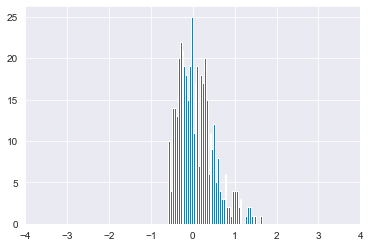

In [38]:
k = 5
plt.hist((distancesMarkedReal[:,1]/np.mean(markedRandom[:,:,1].flatten())) -1, bins = 50)
plt.xlim(-4,4)

In [43]:
distancesMarkedReal[:,1]/np.mean(markedRandom[:,:,1].flatten())

array([1.53890859, 0.89758921, 1.05462445, 0.93504676, 1.94489935,
       1.15492516, 1.94489935, 1.47523499, 1.47523499, 0.89758921,
       1.79738869, 1.92912652, 1.53446125, 1.48523031, 0.84686103,
       1.1266117 , 0.86424377, 0.93504676, 1.30170416, 0.96341242,
       1.15291844, 1.15291844, 1.42416338, 0.86424377, 0.76942459,
       0.81722086, 1.28794074, 1.083077  , 1.18657347, 0.81722086,
       1.30170416, 0.84686103, 1.97046897, 1.86674222, 1.92912652,
       1.53446125, 0.76942459, 0.58759346, 2.16000912, 0.58759346,
       0.84226944, 1.15816886, 1.02230443, 1.58366865, 0.82426397,
       0.66768761, 1.1874983 , 1.24910575, 0.82426397, 1.46170349,
       0.84226944, 0.95227903, 1.24910575, 1.29541517, 0.66768761,
       0.67238346, 1.73782847, 0.95227903, 0.84822205, 1.14306584,
       1.18199699, 1.08333641, 1.41281785, 1.15357305, 1.28031107,
       0.67238346, 1.34381852, 1.15357305, 1.39370698, 1.34381852,
       1.17276566, 1.68778658, 1.30165874, 1.1160561 , 1.58197